### CUNY Data 620 - Web Analytics, Summer 2020  
**Final Project**   
**Prof:** Alain Ledon  
**Members:** Misha Kollontai, Amber Ferger, Zach Alexander, Subhalaxmi Rout 

**Youtube Link:** 

### Instructions
Your project should incorporate one or both of the two main themes of this course: network analysis and text processing. You need to show all of your work in a coherent workflow, and in a reproducible format, such as an IPython Notebook or an R Markdown document. If you are building a model or models, explain how you evaluate the “goodness” of the chosen model and parameters. 

### Research Purpose

For this project, we will be pulling twitter data related to the Coronavirus pandemic in the United States. Our primary objective will be to identify the relationship between city and overall sentiment towards covid. We will look at the average daily tweet sentiment for **NYC** (severe initial wave) and **New Orleans** (experiencing something of a second wave) to see if there are regional differences. From this, we would like to answer the following questions:

* Is there a relationship between location-specific Covid-19 sentiment and the number of positive cases within that region?
* Does positive sentiment preceed spikes in positive cases?

As a secondary objective, we would like to identify relationships between major US cities by looking at shared tweet hashtags. We aim to create a network from these relationships where nodes represent cities and edges represent shared use of hashtags. In doing this, we would like to answer the following questions:

* What issues (additional hashtags) are discussed in conjunction with Covid-19?
* What differences in hashtag use is there across the country?
* Are there certain cities that care about similar issues (additional hashtags)?

As a stretch goal, we would also like to answer the question: Is there a relationship between location-specific Covid-19 hashtags and the number of positive cases within that region? 

### The Data

#### Relevant Cities
First, we generated a list of geocodes that related to the most populous city in each US state (plus DC). This data was pulled from the [1000 Largest US Cities By Population With Geographic Coordinates](https://public.opendatasoft.com/explore/dataset/1000-largest-us-cities-by-population-with-geographic-coordinates/table/?sort=-rank). 


#### Covid-Tweets
Our initial plan was to use the Twitter API to pull in relevant tweets, but we later realized that the API only allows users to pull back 5 days worth of data. Because of this, we turned to the [*GetOldTweets3*](https://pypi.org/project/GetOldTweets3/) package, which allowed us to return tweets with the following specifications:

* **Date Range**: 3/8/2020 - 7/15/2020, pulled in biweekly groupings by city.
* The tweet itself contains the word **Covid** or it is included in one of the hashtags.
* The limit on the total number of tweets per API call is 1000 per date increment. Some of our cities had the full 1000 tweets while others contained less. 

Our final output includes: tweet text, additional hashtags, tweet date, twitter username, and city coordinates. 

Please see the **tweetPull** notebook for more information about the the extraction of relevant tweets. 


#### Covid Case Numbers

We used [John's Hopkins COVID-19 Data](https://github.com/CSSEGISandData/COVID-19) and [Wikipedia](https://en.wikipedia.org/wiki/COVID-19_pandemic_in_the_United_States) for the COVID-19 numbers. 

### Libraries

In [1]:
import pandas as pd
import numpy as np
from itertools import combinations
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
#from mpl_toolkits.basemap import Basemap
import networkx as nx
import warnings
warnings.filterwarnings('ignore')

### Functions

We will define the following functions:
* **sentiment_analyzer_scores**: This will be used to generate the sentiment scores for each tweet.
* **splitTags**: This will be used in splitting up the hashtags into separate entities. 
* **unpack_lat_long**: This will be used to generate separate lists for the latitude and longitude values from the city coordinates. 
* **createEdges**: This will be used to generate a final edge list that is based on shared tweet hashtags.

In [16]:
############### sentiment analysis
def sentiment_analyzer_scores(sentence):
    score = analyser.polarity_scores(sentence)
    neg = score['neg']
    pos = score['pos']
    neu = score['neu']
    compound= score['compound']
    
    return [neg,pos,neu,compound, sentence]

############### splitting hashtag groupings
def splitTags(x,y):
    return [(x,z) for z in y]

############### split coordinates
def unpack_lat_long(lat_long):
    split = lat_long.split(',')
    lat = split[0]
    long = split[1]
    return lat, long

############### create edge list
def createEdges(ls):    
    productList = []
    
    for i in ls:
        if len(i) >1:
            productList.append(list(combinations(i,2)))
    
    return [val for sublist in productList for val in sublist]

### Data
First, we'll pull in our twitter data and our covid cases data. Since our first set of research questions are focused only on New York and New Orleans, we will create separate dataframes for this information. 

#### Twitter Data
We can see that each state has 1000 tweets within the timeframe.

In [91]:
# read in and replace nulls
tweets = pd.read_csv('Covid_Twitter_City_Data.csv', delimiter=',')
tweets = tweets.replace(np.nan, '', regex=True)

nyTweets = tweets[tweets["City"] == "New York"]
noTweets = tweets[tweets["City"] == "New Orleans"]

print('Number of NY tweets: ', nyTweets.shape)
print('Number of New Orleans tweets: ',noTweets.shape)
# nyTweets['Date'].min()

Number of NY tweets:  (1000, 9)
Number of New Orleans tweets:  (1000, 9)


##### Covid Case Data

For our first analysis, we are only concerned 
After locating the correct county FIPS number for New York City, we were able to filter the pandas dataframe to only include this row. Additionally, we transposed this row to ensure we had one column designated for the date and another for the number of confirmed cases for that corresponding date. Finally, we made sure to reset the index and adjust the date type in order to be able to show our visuals . We can take a quick look at the last 5 dates for this filtered dataset:

In [85]:
# load in covid case data
covid_cases = pd.read_csv('confirmed_cases.csv')

# NYC cases
cases_filtered = covid_cases[covid_cases['FIPS'] == 36061]
df = cases_filtered.iloc[:, 11:186:1]

df = df.transpose().reset_index()
df = df.rename(columns={'index': 'Date', 1863: "Confirmed_Cases"})

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')
nyc_time_series.tail()

,Date,Confirmed_Cases
170,2020-07-10,218403
171,2020-07-11,218710
172,2020-07-12,219051
173,2020-07-13,219301
174,2020-07-14,219616


Now, in order to find the number of new cases per day, we can utilize our confirmed cases column to take the difference between the current day and the previous day. Additionally, for our visualization, we can take the 7-day average of new cases and plot this as well, in order to obtain a better view of trends over time. We can also create a function to plot the case counts. 

In [86]:
############### New cases per day
def add_newcases(df):
    df['New_Cases'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i == 0:
            df['New_Cases'][i] = 0
        else:
            df['New_Cases'][i] = df['Confirmed_Cases'][i] - df['Confirmed_Cases'][i-1]
    return df

############### Seven day averages
def add_sevenday(df):
    df['Seven_Day_Avg'] = 'NA'
    for i in range(0, len(df['Confirmed_Cases'])):
        if i < 8:
            df['Seven_Day_Avg'][i] = 0
        else:
            weekly = []
            for y in range(0,7):
                weekly.append(df['New_Cases'][i-y])
            df['Seven_Day_Avg'][i] = sum(weekly) / 7
    return df

############### Plot case counts 
def drawNewCases(df, title, fignum, var):
    var = plt.figure(fignum, figsize=(16,8))
    plt.bar(df['Date'], df['New_Cases'], color='indianred', alpha=0.4)
    plt.plot(df['Date'], df['Seven_Day_Avg'], c='indianred', linewidth=2)
    plt.plot(legend=None)
    plt.title(title)
    plt.ylabel('Number of New Cases')
    plt.gca().xaxis.set_major_formatter(fmt)
    var.show()

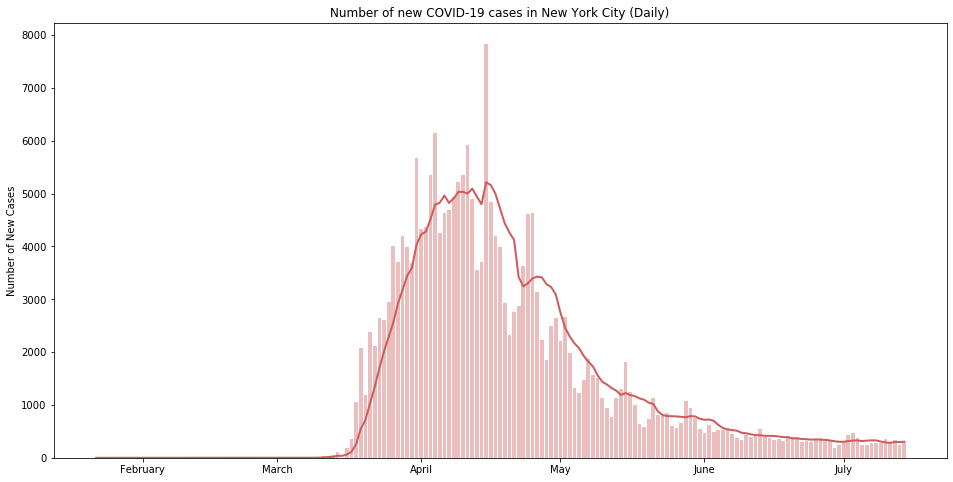

In [90]:
# calculate new cases per day and seven day averages
df = add_newcases(nyc_time_series)
df = add_sevenday(df)

# plot counts
locator = mdates.MonthLocator()
fmt = mdates.DateFormatter('%B')

nyc_time_series = pd.DataFrame(df, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
nyc_time_series['Date'] = pd.to_datetime(nyc_time_series['Date'], format='%m/%d/%y')

drawNewCases(nyc_time_series, 'Number of new COVID-19 cases in New York City (Daily)', 1, 'x')

### Sentiment Analysis

In [19]:
# instantiate sentiment analyzer, define function for sentiment output
analyser = SentimentIntensityAnalyzer()

# sentiments to dataframe
text = tweets['TEXT'].tolist()
sentiments = [sentiment_analyzer_scores(s) for s in text]
sentiments_df = pd.DataFrame(sentiments, columns = ['NEGATIVE_SCORE', 'POSITIVE_SCORE', 'NEUTRAL_SCORE', 'COMPOUND', 'SENTENCE'])

# final dataframe with sentiments
finalFrame = tweets.join(sentiments_df)
finalFrame = finalFrame.iloc[:,1:-1]

#finalFrame.groupby(['City']).mean()

In [53]:
finalFrame.sort_values(by=['POSITIVE_SCORE'], ascending=False).head(10)

,TEXT,HASHTAGS,COORDS,WEEK_START,WEEK_END,City,State,Population,NEGATIVE_SCORE,POSITIVE_SCORE,NEUTRAL_SCORE,COMPOUND
39294,"Awesome, thanks again!!",,"38.9071923,-77.0368707",2020-03-08,2020-07-15,Washington,District of Columbia,646449,0.0,0.884,0.116,0.8217
34658,Yes. THANKS Covid,,"41.8781136,-87.6297982",2020-03-08,2020-07-15,Chicago,Illinois,2718782,0.0,0.864,0.136,0.7456
5033,Thank God! #Covid_19,#Covid_19,"40.7607793,-111.8910474",2020-03-08,2020-07-15,Salt Lake City,Utah,191180,0.0,0.830,0.170,0.5983
35536,WOW. #COVID__19,#COVID__19,"43.6187102,-116.2146068",2020-03-08,2020-07-15,Boise City,Idaho,214237,0.0,0.792,0.208,0.5859
13158,COVID Free,,"35.4675602,-97.5164276",2020-03-08,2020-07-15,Oklahoma City,Oklahoma,610613,0.0,0.767,0.233,0.5106
28393,Covid free,,"43.661471,-70.2553259",2020-03-08,2020-07-15,Portland,Maine,66318,0.0,0.767,0.233,0.5106
7311,Covid kisses.,,"35.1495343,-90.0489801",2020-03-08,2020-07-15,Memphis,Tennessee,653450,0.0,0.767,0.233,0.5106
40743,COVID safe. Good thinking.,,"39.7390721,-75.5397878",2020-03-08,2020-07-15,Wilmington,Delaware,71525,0.0,0.744,0.256,0.7003
21842,Wow! That is excellent! Good for you!,,"45.7832856,-108.5006904",2020-03-08,2020-07-15,Billings,Montana,109059,0.0,0.738,0.262,0.9057
4439,"Dear COVID-19,",,"44.4758825,-73.212072",2020-03-08,2020-07-15,Burlington,Vermont,42284,0.0,0.722,0.278,0.3818


### Creating a Network
* **Nodes**: Cities, **TO DO: color: sentiment, size: portion of population affected by covid**
* **Edges**: Shared Hashtags, **TO DO: edge weights: number of shared hashtags**

#### Hashtags by Coordinate

In [4]:
# hashtags & coordinates for each record
hashtags = tweets['HASHTAGS'].tolist()
coords = tweets['COORDS'].tolist()
sepHash = [i.split() for i in hashtags]
sepHash[1:5]

[[], [], [], ['#CX', '#COVID', '#custserv']]

In [5]:
# set of all coordinates with individual hashtag
coordTag = [splitTags(i,j) for i,j in list(zip(coords,sepHash)) if len(j)> 0]
flattened = [val for sublist in coordTag for val in sublist]
finalHash = set(flattened)

# create a dictionary of each hashtag with the city coordinates
tempDict = {}
for i,j in finalHash:
    if j not in tempDict:
        tempDict[j]= [i]
    else:
        tempDict[j].append(i)
        
# remove covid hashtags from dictionary
tagsToRemove = ['#covid_19', '#COVID19', '#COVID2019', '#COVID_19', '#COVID__19', '#COVID', '#CoronavirusUSA', '#CV19',
                '#COVD19', '#Covid_19', '#CORONAVIRUS', '#Coronavirus', '#CoronavirusCOVID', '#Corona', '#Coronovirus',
               '#CoronavirusOubreak', '#CoronavirusPandemic', '#CoronavirusOutbreak', '#CoronavirusPandemic', '#coronavirus', 
                '#Covid19', '#covid', '#Covid', '#covid19', '#pandemic', '#corona']

for k in tagsToRemove:
    tempDict.pop(k, None)

print('Example output from the hashtag #FollowTheScience:')
tempDict['#FollowTheScience']

Example output from the hashtag #FollowTheScience:


['38.9071923,-77.0368707',
 '41.8781136,-87.6297982',
 '39.9525839,-75.1652215',
 '34.7464809,-92.2895948',
 '39.7392358,-104.990251',
 '47.6062095,-122.3320708',
 '34.0522342,-118.2436849',
 '39.9611755,-82.9987942']

In [39]:
len(tempDict['#VoteBlueToSaveAmerica2020'])
#sorted(tempDict['#BlackLivesMatter'])

#list(set(tempDict['#VoteBlueToSaveAmerica2020']) & set(tempDict['#BlackLivesMatter']))


print('business: ' , len(tempDict['#business']))
print('stay home: ' , len(tempDict['#stayhome']))
print('both: ', len(set(tempDict['#business']) & set(tempDict['#stayhome'])))

business:  15
stay home:  13
both:  5


#### Top Hashtags 
Let's take a look at the hashtags used in the highest number of cities. #WearAMask and #COVIDIOTS in particular stand out. 

In [28]:
# top hashtags
hsh = []
ties = []
for key, value in tempDict.items():
    hsh.append(key)
    ties.append(len(value))
Hash_Ties = pd.DataFrame()
Hash_Ties['Hashtag'] = hsh
Hash_Ties['Cities'] = ties
Hash_Ties = Hash_Ties.sort_values(by=['Cities'],ascending = False)
Hash_Ties.head(10)

,Hashtag,Cities
81,#WearAMask,41
135,#COVIDIOTS,32
948,#TMobileTuesdays,28
2,#SmartNews,27
334,#contest,27
385,#TrumpVirus,27
2655,#SocialDistancing,26
407,#BlackLivesMatter,26
75,#MaskUp,25
359,#WearADamnMask,25


In [18]:
#### Final Edges
# combining all elements in the dictionary values into separate node connections
coordPairs = list(tempDict.values())
finalPairs = createEdges(coordPairs)

print('Example Edge:', finalPairs[1])

Example Edge: ('38.9071923,-77.0368707', '41.6005448,-93.6091064')


In [14]:
# split into 2 subnetworks
magaTweets = tempDict['#MAGA']
tindTweets = tempDict['#TrumpIsANationalDisgrace']

['43.661471,-70.2553259',
 '40.7127837,-74.0059413',
 '41.6005448,-93.6091064',
 '30.3321838,-81.655651',
 '41.8781136,-87.6297982',
 '39.7390721,-75.5397878',
 '35.0853336,-106.6055534',
 '33.7489954,-84.3879824',
 '42.331427,-83.0457538',
 '40.735657,-74.1723667',
 '42.3600825,-71.0588801',
 '34.0007104,-81.0348144',
 '38.9071923,-77.0368707',
 '36.8529263,-75.977985',
 '61.2180556,-149.9002778',
 '35.2270869,-80.8431267']

#### Visualize Network

In [ ]:
# separate lists for latitude and longitude
temp= tempDict['#WearAMask']
WearMask_lat = []
WearMask_long = []
for city in temp:
    lat, long = unpack_lat_long(city)
    WearMask_lat.append(round(float(lat),2))
    WearMask_long.append(round(float(long),2))
WearMask_long[:5]

In [ ]:
fig = plt.figure(num=None, figsize=(12, 8) ) 
#m = Basemap(width=6000000,height=4500000,resolution='c',projection='aea',lat_1=35.,lat_2=45,lon_0=-100,lat_0=40)
m = Basemap(
        projection='merc',
        llcrnrlon=-130,
        llcrnrlat=25,
        urcrnrlon=-60,
        urcrnrlat=50,
        lat_ts=0,
        resolution='i',
        suppress_ticks=True)

mx, my = m(WearMask_long,WearMask_lat)

G = nx.Graph()
G.add_nodes_from(temp)
pos = {}
i = 0
for city in temp:
    
    pos[city] = (mx[i],my[i])
    i+=1
    
nx.draw_networkx(G,pos, node_size = 200, node_color = 'red',with_labels = False)
m.drawcoastlines(linewidth=0.5)
m.fillcontinents(color='tan',lake_color='lightblue')
# draw parallels and meridians.
m.drawparallels(np.arange(-90.,91.,15.),labels=[True,True,False,False],dashes=[2,2])
m.drawmeridians(np.arange(-180.,181.,15.),labels=[False,False,False,True],dashes=[2,2])
m.drawmapboundary(fill_color='lightblue')
m.drawcountries(linewidth=2, linestyle='solid', color='k' ) 
m.drawstates(linewidth=0.5, linestyle='solid', color='k')  


### Edge Weights
https://www.geeksforgeeks.org/python-program-to-count-duplicates-in-a-list-of-tuples/

### Step 1: Scraping Twitter Data from New York City & New Orleans

As a first step, we decided to scrape tweets from two locations, New York City and New Orleans.

### Step 2: Pulling coronavirus case numbers for both locations

##### Filtering for New Orleans Cases

In [ ]:
cases_filtered_newo = covid_cases[covid_cases['FIPS'] == 22071]

df_newo = cases_filtered_newo.iloc[:, 11:186:1]

df_newo = df_newo.transpose().reset_index()
df_newo = df_newo.rename(columns={'index': 'Date', 1153: "Confirmed_Cases"})

newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

In [ ]:
newo_time_series.tail()

In [ ]:
df_newo = add_newcases(newo_time_series)
df_newo = add_sevenday(df_newo)

In [ ]:
newo_time_series = pd.DataFrame(df_newo, columns = ['Date','Confirmed_Cases', 'New_Cases', 'Seven_Day_Avg'])
newo_time_series['Date'] = pd.to_datetime(newo_time_series['Date'], format='%m/%d/%y')

In [ ]:
drawNewCases(newo_time_series, 'Number of new COVID-19 cases in New Orleans (Daily)', 2, 'y')

**Note from Zach**: Will remove this commented-out code later (see below), but thought I'd leave it just in case it'll be helpful for future visualizations:

In [ ]:
# locator = mdates.MonthLocator()
# fmt = mdates.DateFormatter('%B')


# plt.plot(nyc_time_series['Date'], nyc_time_series['Confirmed_Cases'], c='indianred')
# plt.plot(legend=None)
# plt.title('Number of Confirmed COVID-19 Cases in New York City')
# plt.xlabel('Date')
# plt.ylabel('Number of Confirmed Cases')
# plt.gca().xaxis.set_major_formatter(fmt)
# plt.show()